In [1]:
import pandas as pd
from matplotlib import pyplot as plt
import geopandas as gpd
import numpy as np
import pandas as pd
import shapely
import plotly.express as px
import osmnx as ox

Las isocronas son calculadas con el paquete urbanpy, mediante la API de OSRM. Ver metodología aquí: https://colab.research.google.com/drive/1aRybqbsKerVAyJwsRYdSdvXz7V9F3XmN


(Nótese que para correr urbanpy es necesario levantar una instancia de Docker en Linux)

In [2]:
isocronas = gpd.read_file('data/BBDD Perú accesibilidad/centros_discapacidad_isocronas.geojson')

In [3]:
isocronas.head()

,group_index,contour,geometry
0,0,30,"POLYGON ((-77.07056 -12.10133, -77.08173 -12.0..."
1,0,25,"POLYGON ((-77.07060 -12.09881, -77.07079 -12.0..."
2,0,20,"POLYGON ((-77.07344 -12.09654, -77.07385 -12.0..."
3,0,15,"POLYGON ((-77.07353 -12.09363, -77.07708 -12.0..."
4,0,10,"POLYGON ((-77.07245 -12.09063, -77.07273 -12.0..."


In [4]:
isocronas.shape

(3168, 3)

In [5]:
def osmnx_graph(
    download_type: str,
    network_type="drive",
    query_str=None,
    geom=None,
    distance=None,
    **kwargs,
):
    """
    Download a graph from OSM using osmnx.

    Parameters
    ----------
    download_type: str. One of {'polygon', 'place', 'point'}
        Input download type. If polygon, the polygon parameter must be provided
        as a Shapely Polygon.
    network_type: str. One of {'drive', 'drive_service', 'walk', 'bike', 'all', 'all_private'}
        Network type to download. Defaults to drive.
    query_str: str (Optional).
        Only requiered for place type downloads. Query string to download a network.
    polygon: Shapely Polygon or Point (Optional).
        Polygon requiered for polygon type downloads, Point for place downloads.
        Polygons are used as bounds for network download, points as the center.
        with a distance buffer.
    distance: int
        Distance in meters to use as buffer from a point to download the network.

    Returns
    -------
    G: networkx.MultiDiGraph
        Requested graph with simplyfied geometries.

    Examples
    --------
    >>> poly = urbanpy.download.nominatim_osm('San Isidro, Peru')
    >>> G = urbanpy.download.osmnx_graph('polygon', geom=lima.loc[0,'geometry'])
    >>> G
    <networkx.classes.multidigraph.MultiDiGraph at 0x1a2ba08150>
    """
    if (
        (download_type == "polygon")
        and (geom is not None)
        and isinstance(geom, Polygon)
    ):
        G = ox.graph_from_polygon(geom, network_type=network_type)
        return G
    elif (download_type == "point") and (geom is not None) and (distance is not None):
        G = ox.graph_from_point(geom, dist=distance, network_type=network_type)
        return G

    elif download_type == "place" and query_str is not None:
        G = ox.graph_from_place(query_str, network_type=network_type)
        return G

    elif download_type == "polygon" and geom is None:
        print("Please provide a polygon to download a network from.")

    elif download_type == "place" and query_str is None:
        print("Please provide a query string to download a network from.")

    else:
        if distance is None and download_type == "point":
            print("Please provide a distance buffer for the point download")

        if geom is None and distance is not None:
            print("Please provide a Point geometry.")

Descargamos un mapa base con la grilla de calles de la ciudad de Lima. 

In [6]:
lima_grilla = osmnx_graph('place', 'walk', 'Lima, Perú')

In [7]:
lima_grilla  = ox.project_graph(lima_grilla)

In [9]:
edges = ox.graph_to_gdfs(lima_grilla, nodes=False, edges=True)


In [12]:
print("Isocronas CRS: ", isocronas.crs)
print("Graph edges CRS: ", edges.crs)

Isocronas CRS:  EPSG:4326
Graph edges CRS:  EPSG:32718


Tenemos que reproyectar uno de los mapas:

In [13]:
if isocronas.crs != edges.crs:
    isocronas = isocronas.to_crs(edges.crs)

In [14]:
print("Isocronas CRS: ", isocronas.crs)
print("Graph edges CRS: ", edges.crs)

Isocronas CRS:  EPSG:32718
Graph edges CRS:  EPSG:32718


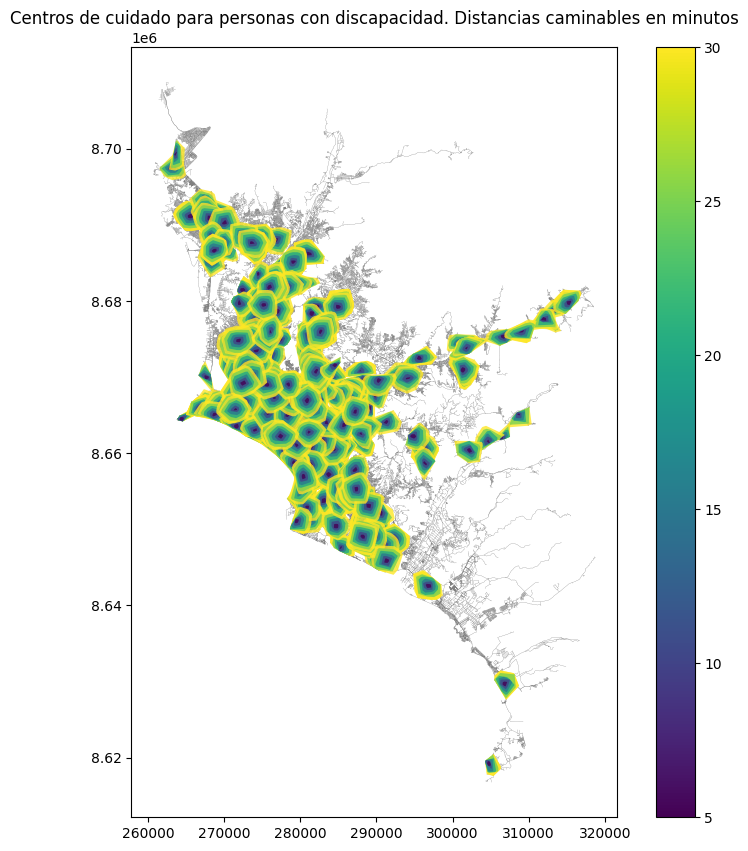

In [17]:
fig, ax = plt.subplots(figsize=(10, 10))
edges.plot(ax=ax, linewidth=.1, edgecolor='gray', zorder=1)

# Overlay the isocronas
isocronas.plot(ax=ax, column='contour', alpha=0.8, zorder=2, legend=True)

# Set plot title
plt.title("Centros de cuidado para personas con discapacidad. Distancias caminables en minutos")

# Show the plot
plt.show()

Tenemos isocronas que se superponen, así que reordenamos el dataset para que las isocronas se ordenen de forma descendente respecto a su valor de tiempo, lo cual hace que se grafiquen de forma más prolija

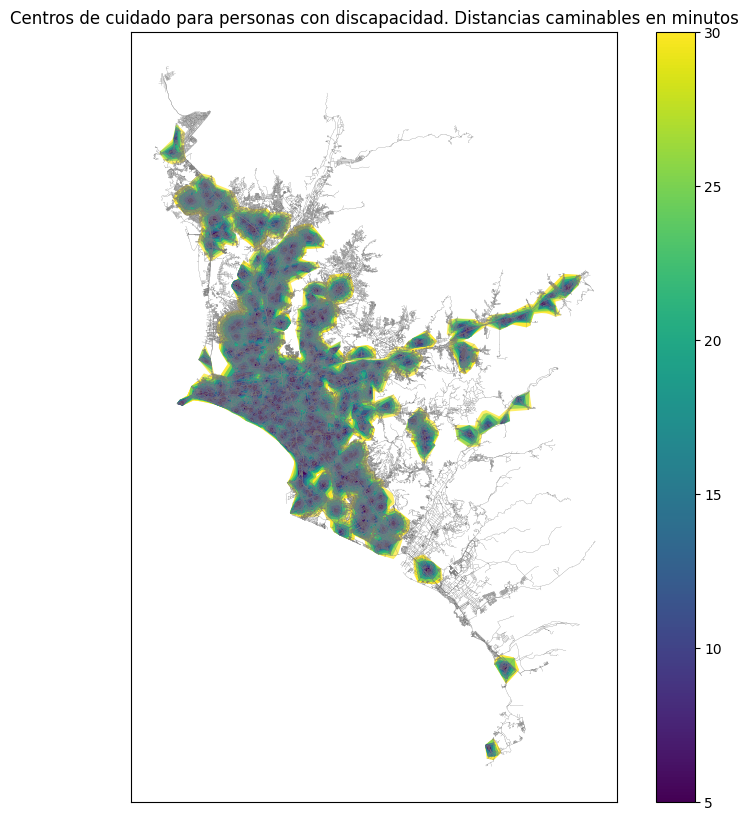

In [22]:
fig, ax = plt.subplots(figsize=(10, 10))
edges.plot(ax=ax, linewidth=.1, edgecolor='gray')

# Overlay the isocronas
isocronas.sort_values(by='contour', ascending=False).plot(ax=ax, column='contour', alpha=0.7, zorder=1, legend=True)

ax.set_xticks([])
ax.set_yticks([])

# Set plot title
plt.title("Centros de cuidado para personas con discapacidad. Distancias caminables en minutos")

# Save
plt.savefig('figs/isocronas discapacidad.png', format='png', dpi=1500)

# Show the plot
plt.show()
